In [12]:
import leaderbot as lb
import numpy as np
import pickle
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import texplot

In [2]:
# Load form file instead
filename = '../benchmark/models_train_full.pkl'
#filename = '../benchmark/models_train_split.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

models = results['models']

models_config = np.array([
    ['BT2',  '',   ''],
    ['BT2', '0',   ''],
    ['BT2', '3',   ''],
    ['BT',   '',   ''],
    ['BT',  '0',   ''],
    ['BT',  '3',   ''],
    ['RK',   '',  '0'],
    ['RK',   '',  '1'],
    ['RK',   '', '10'],
    ['RK',   '', '20'],
    ['RK',  '0',  '0'],
    ['RK',  '0',  '1'],
    ['RK',  '0', '10'],
    ['RK',  '0', '20'],
    ['RK',  '3',  '0'],
    ['RK',  '3',  '1'],
    ['RK',  '3', '10'],
    ['RK',  '3', '20'],
    ['DV',   '',  '0'],
    ['DV',   '',  '1'],
    ['DV',   '', '10'],
    ['DV',   '', '20'],
    ['DV',  '0',  '0'],
    ['DV',  '0',  '1'],
    ['DV',  '0', '10'],
    ['DV',  '0', '20'],
    ['DV',  '3',  '0'],
    ['DV',  '3',  '1'],
    ['DV',  '3', '10'],
    ['DV',  '3', '20'],
])

def get_model_names(models_config):

    model_names = []

    for i in range(models_config.shape[0]):
    
        name = models_config[i, 0]
        cov = models_config[i, 1]
        tie = models_config[i, 2]

        no_symbol = r'\ding{55}'

        # Name
        if name == 'BT2':
            name = r'\textsf{' + 'BT' + '}' + r'\textsuperscript{\ding{93}}'
        else:
            name = r'\textsf{' + name + '}'

        # Cov
        if cov == '':
            cov = no_symbol
        else:
            cov = r'\textsf{' + cov + '}'

        # Tie
        if tie == '':
            tie = no_symbol
        else:
            tie = r'\textsf{' + tie + '}'

        # model_name = name + ' ' + cov + ' ' + tie  

        model_names.append([name, cov, tie])

    return np.array(model_names)

model_names = get_model_names(models_config)

In [3]:
ranks = []
scores = []
for model in models:
    ranks.append(model.rank())
    scores.append(model.scores())
ranks = np.array(ranks)
scores = np.array(scores)

In [4]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import optimal_leaf_ordering

def reorder(matrix):

    # Perform hierarchical clustering
    # linkage = sch.linkage(matrix, method='average')
    linkage = sch.linkage(matrix, method='average', metric='euclidean', optimal_ordering=True)
    #linkage = sch.linkage(matrix, method='average', optimal_ordering=True)
    
    # Compute optimal leaf ordering
    ordered_linkage = optimal_leaf_ordering(linkage, matrix)
    
    # Reorder based on optimal leaf ordering
    dendro = sch.dendrogram(ordered_linkage, no_plot=True)
    indices = dendro['leaves']
    
    # Reorder the matrix
    reordered_matrix = matrix[np.ix_(indices, indices)]

    return reordered_matrix, indices

In [13]:
def cor_plot(fig, ax, matrix, names, horizontal=True, cmap=None):
    """
    """

    ax.set_frame_on(False)
    ax.set_aspect(2.0)

    n = matrix.shape[0]

    if horizontal:
        matrix = np.triu(matrix)
    # else:
    #     matrix = np.tril(matrix)
    matrix = np.ma.masked_array(matrix, matrix == 0)
    
    # Set the diagonal to zero.
    for i in range(n):
        matrix[i, i] = 1

    #if not horizontal:
    matrix = np.flipud(matrix)
    #matrix = np.fliplr

    # Transformation matrix for rotating the heatmap.
    #A = np.array([(y, x) for x in range(n, -1, -1) for y in range(n + 1)])
    x_ = np.linspace(-0.5, 0.5, n+1)
    y_ = np.linspace(-0.5, 0.5, n+1)

    if horizontal is False:
        x_ = x_[::-1]
        
    A = np.array([(y, x) for x in x_ for y in y_])
    t = np.array([[0.5, 1.0],
                  [0.5, -1.0]])
    A = np.dot(A, t)

    min_val =np.min(matrix)
    min_val = np.floor(min_val * 100.0) / 100.0
    n_snaps = int(100 - min_val * 100.0)
    
    if cmap is None:
        cmap = plt.cm.cividis
    norm = matplotlib.colors.BoundaryNorm(np.linspace(min_val, 1, 4*n_snaps+1), cmap.N)

    # This MUST be before the call to pl.pcolormesh() to align properly.
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot the correlation heatmap triangle.
    X = A[:, 1].reshape(n + 1, n + 1)
    Y = A[:, 0].reshape(n + 1, n + 1)
    caxes = ax.pcolormesh(X, Y, matrix, axes=ax, cmap=cmap, norm=norm,
                          edgecolors=(0.5, 0.5, 0.5, 0.2), linewidth=0.1)

    # Plotting the border
    ax.plot([X[-1, 0], X[-1, -1], X[0, -1], X[-1, 0]], 
            [Y[-1, 0], Y[-1, -1], Y[0, -1], Y[-1, 0]],
            color='black', lw=0.65, zorder=10)

    for i in range(n):
        ax.text(X[n-i, i] + 1/n, Y[n-i, i] - 0.25/n, names[i][0], ha='center', va='top', rotation=-90, zorder=20)
        ax.text(X[n-i, i] + 1/n, Y[n-i, i] - 2.0/n, names[i][1], ha='center', va='center', rotation=0, zorder=20)
        ax.text(X[n-i, i] + 1/n + 0.005, Y[n-i, i] - 3.3/n, names[i][2], ha='center', va='center', rotation=0, zorder=20)

    # Remove the ticks and reset the x limit.
    if horizontal:
        ax.set_ylim(bottom=0)
    else:
        ax.set_xlim(right=0)

    # Add a colorbar below the heatmap triangle.
    cb = fig.colorbar(caxes, ax=ax, orientation='horizontal', shrink=0.5825,
                      fraction=0.05, pad=-0.035, ticks=np.linspace(min_val, 1, n_snaps+1),
                      use_gridspec=True)
    cb.set_label(r"Kendall $\boldsymbol{\tau}$ Correlation")
    
    # Set colorbar tick labels as percentages
    ticks = cb.get_ticks()
    cb.set_ticks(ticks)
    #cb.set_ticklabels([f'{100 * tick:.0f}%' for tick in ticks])
    cb.set_ticklabels([rf'${100 * tick:.0f}\%$' for tick in ticks])

    cb.ax.set_position([0.178, 0.1345, 0.27, 0.4])

    return X, Y

In [14]:
order = np.array([30, 18, 26, 14, 22, 10, 6, 3, 19, 7, 4, 1]) - 1

#n_models = order.size
n_models = scores.shape[0]
stat= np.zeros((n_models, n_models), dtype=float)
pvalue = np.zeros((n_models, n_models), dtype=float)

rng = slice(None, None)

for i in range(n_models):
    for j in range(i, n_models):
        res = stats.kendalltau(scores[i, rng], scores[j, rng], variant='b', alternative='two-sided')
        
        stat[i, j] = res.statistic
        stat[j, i] = stat[i, j]
        pvalue[i, j] = res.pvalue
        pvalue[j, i] = pvalue[i, j]

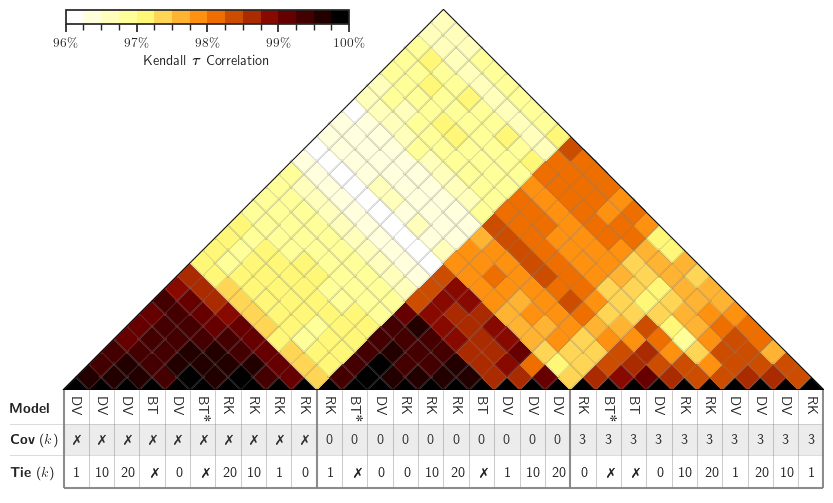

In [15]:
# fig, ax = plt.subplots(figsize=(14, 14))
fig = plt.figure(figsize=(10.5, 12))
gs = GridSpec(2, 1, height_ratios=[5, 1], hspace=-0.09)

ax_top = fig.add_subplot(gs[0])
ax_top.set_aspect(2.0)
ax_top.set_frame_on(False)  # Turn off the frame

ordered_stat, indices = reorder(stat)

# indices = np.array([
#     4, 1, 7, 8, 9, 10, 19, 20, 21, 22,
#     6, 3, 15, 16, 17, 18, 27, 28, 29, 30,
#     5, 2, 11, 12, 13, 14, 23, 24, 25, 26,
# ]) - 1

indices = np.r_[indices[:10], indices[20:], indices[10:20]]


ordered_stat = stat[np.ix_(indices, indices)]
ordered_names = model_names[indices]

# with texplot.theme(rc=rc, use_latex=True):

rc = {
    'font.family': 'sans-serif',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{amsfonts} \usepackage{pifont}',
}


with texplot.theme(use_latex=True, font_scale=0.85):
    plt.rcParams.update(rc)

    cmap = plt.cm.afmhot_r
    
    X, Y = cor_plot(fig, ax_top, ordered_stat, ordered_names, horizontal=True, cmap=cmap)
    
    ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
    ax_bottom.set_aspect(0.24)
    
    # Hide all tick marks and labels
    ax_bottom.set_xticks([])
    ax_bottom.set_yticks([])
    
    # Hide axis frame
    ax_bottom.axis('off')
    
    # Invert the y-axis so that zero is at the boundary between the two axes
    ax_bottom.invert_yaxis()
    
    n = X.shape[0]
    epsilon = 0.003
    for i in range(n):
        x = 2.0*(X[i, i]+Y[i, i])
        if i == 0: x += epsilon
        if i == n-1: x -= epsilon
        if i % 10 == 0:
            linewidth = 1.5
            color = (0.5, 0.5, 0.5, 0.9)
        else:
            linewidth = 0.75
            color = (0.5, 0.5, 0.5, 0.4)
        ax_bottom.vlines(x, 0.27, 1.35, color=color, linewidth=linewidth)
    
    ax_bottom.text(-1.14, 0.52, r'\textbf{Model}')
    ax_bottom.text(-1.14, 0.87, r'\textbf{Cov} ($k$)')
    ax_bottom.text(-1.14, 1.23, r'\textbf{Tie} ($k$)')
    
    #ax_bottom.hlines(0.22, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    ax_bottom.hlines(0.65, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    ax_bottom.hlines(0.99, -1.15, 1, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    ax_bottom.hlines(1.35, -1+epsilon, 1-epsilon, color=(0.5, 0.5, 0.5, 0.9), linewidth=1.5)
    #ax_bottom.vlines(-1.15, 0.22, 1.25, color=(0.5, 0.5, 0.5, 0.4), linewidth=0.5)
    
    ax_bottom.add_patch(plt.Rectangle((-1+epsilon, 0.65), 2-2*epsilon, 0.99-0.65, facecolor=(0.5, 0.5, 0.5, 0.15),
                                      edgecolor='none', zorder=-1000))
    
    ax_bottom.set_xlim(left=-1.14)
    
    
    plt.savefig('kendall.pdf', bbox_inches='tight', pad_inches=0)
    
    plt.show()

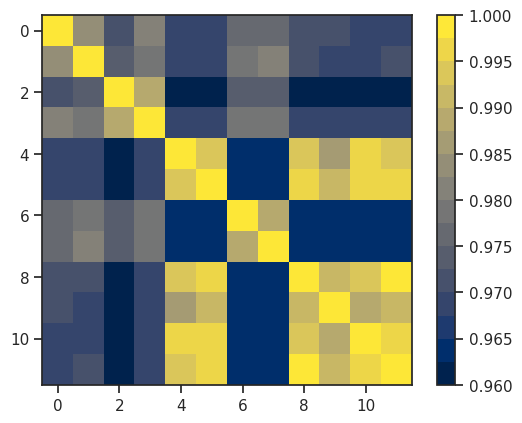

In [10]:
cmap = plt.cm.get_cmap('cividis', 16)

with texplot.theme(use_latex=False):
    p = plt.imshow(stat[np.ix_(order, order)], cmap=cmap, vmin=0.96, vmax=1)
    #p = plt.imshow(reorder(stat)[0], cmap=cmap, vmin=0.96, vmax=1)
    #p = plt.imshow(pvalue, cmap=cmap, norm=LogNorm(vmin=1e-7, vmax=1e0))
    plt.colorbar(p)